In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import numpy as np
from scipy import signal
from scipy import stats
import matplotlib.pyplot as plt
import cv2
import os
from scipy import interpolate

In [3]:
def area_of_triangle(A,B,C):
    """
    computes the area of a triangle given by 3 points in 2d or 3d coordinates
    A, B and C must be numpy arrays
    it works with vectors A=[a1,a2,a3], B=[b1,b2,b3], c=[c1,c2,c3]
    or matrices
    A=[[a11,a12,a13],...[a1n,a2n,b3n]], B=[[b11,b12,b13],...[b1n,b2n,b3n]], C=[[c11,c12,c13],...[c1n,c2n,c3n]]
    """
    
    As = A.shape
    Bs = B.shape
    Cs = C.shape
    
    if len(As) == 1 : 
        #we got vectors
        if (As[1]>3) or (Bs[1]>3) or (Cs[1]>3):
            raise Exception('coordinates can only be 2d or 3d')
            return None
    else:
        #check at least one of the dimensions is two or three
        if (As[0]==2) or (As[0]==3) or (As[1]==2) or (As[1]==3):
            #one of the dimensions of A is 2 or 3, now check that all the vectors have the same size
            if (As!=Bs) or (As!=Cs):
                raise Exception('vectors must be the same size')
                return None
            else:
                #move forward
                pass
        else:
            raise Exception('coordinates can only be 2d or 3d')
            return None
        
    
    #at this point we know that one of the dimensions has 2 or 3 elements we move  forward assuming that 
    #the user provided the vectors with the correct size

    #move all vectors to the same origin -> A
    AB = B-A
    AC = C-A
    
    if len(As) == 1 :
        if As[1]==3:
            #if only one vector then simply compute the norm of the cross product
            area = (1/2)*np.linalg.norm(np.cross(AB,AC))
        else:
            AB = np.column_stack((AB,np.zeros((As[0],1))))
            AC = np.column_stack((AC,np.zeros((As[0],1))))
            area = (1/2)*np.linalg.norm(np.cross(AB,AC)) 
    else:
        if As[1]==3:
            #if  multiple vectors compute the norm along the axis one 
            area = (1/2)*np.linalg.norm(np.cross(AB,AC), axis = 1)  
        else:
            AB = np.column_stack((AB,np.zeros((As[0],1))))
            AC = np.column_stack((AC,np.zeros((As[0],1))))
            area = (1/2)*np.linalg.norm(np.cross(AB,AC), axis = 1)     
    
    return area

def three_point_difference(x,time=None):
    #computes three point difference for derivative 
    
    if time is None:
        h = 1
    else:
        h = np.mean(np.diff(time))
        
    
    dx = np.zeros(x.shape)
    dx[0] = (1/(2*h))*(-3*x[0]+4*x[1]-x[2])
    dx[1] = (1/(2*h))*(-x[0]+x[2])
    dx[2:]= (1/(2*h))*(x[0:-2]-4*x[1:-1]+3*x[2:])
    
    return dx

def adjust_amplitude_and_time(sig, time,normalize=True, des_n = None):
    """
    Takes a signal x of lengt n and return a new signal x_n of lenght des_n and with zero meand and unit standard deviation
    
    Interpolation is performed using cubic splines
    """
    sig = sig[:,None]
    time = time [:,None]
    
    if des_n is None:
        des_time = time
    else:
        des_time = np.linspace(time[0],time[-1],des_n)
 
    if normalize:
        sig = (sig-np.mean(sig))/np.std(sig)
    try:
        tck = interpolate.splrep(time, sig, s=0)
    except:
        tck = interpolate.splrep(np.sort(time,axis=None), sig, s=0)
    
    new_sig = interpolate.splev(des_time, tck, der=0)
    
    new_sig_der = interpolate.splev(des_time, tck, der=1)
    
    return new_sig, des_time, new_sig_der 
    
def compute_excentricity(W,O):
    """
    Compute the excentricity of a ellipsis with wide W and opening  O
    """
    e = np.zeros(W.shape)
    for k,n in enumerate(zip(W,O)):
        w,o = abs(n[0]),abs(n[1])
        if w<o:
            e[k] = np.sqrt(1-(w/o)**2)
        elif w>o:
            e[k] = np.sqrt(1-(o/w)**2)
        else: 
            e[k] = 1
    
    return e
            

def concordance_correlation_coefficient(s1, s2):
    """
    computes Lin's concordance correlation coefficient between two time-series 
    Lin, Lawrence I-Kuei. March, 1989. 'A Concordance Correlation Coefficient to Evaluate Reproducibility.'Biometrics 45, 255-268.
    
    """
    N1 = len(s1)
    N2 = len(s2)
    if N1==N2:
        N = N1
    elif N1>N2:
        s1 = s1[0:N2]
        N = N2
    elif N1<N2:
        s2 = s2[0:N1]
        N = N1
        
    m_s1 = np.mean(s1)
    m_s2 = np.mean(s2)
    
    s1_nomean = s1-m_s1
    s2_nomean = s2-m_s2
    
    s1_ss2 = (1/N)*np.sum((s1_nomean)**2)
    s2_ss2 = (1/N)*np.sum((s2_nomean)**2)
       
    s1s2 = (1/N)*np.sum(np.multiply(s1_nomean,s2_nomean)) # np.multiply(A,B) -> element wise multiplication between matrices A and B
    
    p = (2*s1s2)/(s1_ss2 + s2_ss2 +(m_s1 - m_s2)**2)
    
    return p

def get_mouth_positions_3d(DF,coord='3d'):

    #DF_3dpositions is a DataFrame

    #we are goinf to focus on the rihgt and left corners of the mouth and the top and bottom lips 
    #these positions correspond to landmarks 48, 54 and 51, 57 respectivelly
    if coord is '3d':
        DF_3dpositions = DF
        Right_corner = DF_3dpositions.filter(like='landmark_48')
        Right_corner_x = Right_corner.iloc[1:,[0]].values
        Right_corner_y = Right_corner.iloc[1:,[1]].values
        Right_corner_z = Right_corner.iloc[1:,[2]].values
        Right_Corner_Coord = np.column_stack((Right_corner_x.astype(np.double),Right_corner_y.astype(np.double),Right_corner_z.astype(np.double)))

        Left_corner = DF_3dpositions.filter(like='landmark_54')
        Left_corner_x = Left_corner.iloc[1:,[0]].values
        Left_corner_y = Left_corner.iloc[1:,[1]].values
        Left_corner_z = Left_corner.iloc[1:,[2]].values
        Left_Corner_Coord = np.column_stack((Left_corner_x.astype(np.double),Left_corner_y.astype(np.double),Left_corner_z.astype(np.double)))

        Top_lip = DF_3dpositions.filter(like='landmark_51')
        Top_lip_x = Top_lip.iloc[1:,[0]].values
        Top_lip_y = Top_lip.iloc[1:,[1]].values
        Top_lip_z = Top_lip.iloc[1:,[2]].values
        Top_Lip_Coord = np.column_stack((Top_lip_x.astype(np.double),Top_lip_y.astype(np.double),Top_lip_z.astype(np.double)))

        Bottom_lip = DF_3dpositions.filter(like='landmark_57')
        Bottom_lip_x = Bottom_lip.iloc[1:,[0]].values
        Bottom_lip_y = Bottom_lip.iloc[1:,[1]].values
        Bottom_lip_z = Bottom_lip.iloc[1:,[2]].values
        Bottom_Lip_Coord = np.column_stack((Bottom_lip_x.astype(np.double),Bottom_lip_y.astype(np.double),Bottom_lip_z.astype(np.double)))

        Nose_tip= DF_3dpositions.filter(like='landmark_30')
        Nose_tip_x = Nose_tip.iloc[1:,[0]].values
        Nose_tip_y = Nose_tip.iloc[1:,[1]].values
        Nose_tip_z = Nose_tip.iloc[1:,[2]].values
        Nose_Tip_Coord = np.column_stack((Nose_tip_x.astype(np.double),Nose_tip_y.astype(np.double),Nose_tip_z.astype(np.double)))
        
        norm_factor = 1

    else:
        #DF_3dpositions is a DataFrame

        #we are goinf to focus on the rihgt and left corners of the mouth and the top and bottom lips 
        #these positions correspond to landmarks 48, 54 and 51, 57 respectivelly
        
        DF_2dpositions = DF
        
        Right_corner_x = DF_2dpositions.filter(like='landmark_48_x').values
        Right_corner_y = DF_2dpositions.filter(like='landmark_48_y').values
        Right_Corner_Coord = np.column_stack((Right_corner_x.astype(np.double),Right_corner_y.astype(np.double)))

        Left_corner = DF_2dpositions.filter(like='landmark_54')
        Left_corner_x = DF_2dpositions.filter(like='landmark_54_x').values
        Left_corner_y = DF_2dpositions.filter(like='landmark_54_y').values
        Left_Corner_Coord = np.column_stack((Left_corner_x.astype(np.double),Left_corner_y.astype(np.double)))

        Top_lip_x = DF_2dpositions.filter(like='landmark_51_x').values
        Top_lip_y = DF_2dpositions.filter(like='landmark_51_y').values
        Top_Lip_Coord = np.column_stack((Top_lip_x.astype(np.double),Top_lip_y.astype(np.double)))

        Bottom_lip_x = DF_2dpositions.filter(like='landmark_57_x').values
        Bottom_lip_y = DF_2dpositions.filter(like='landmark_57_y').values
        Bottom_Lip_Coord = np.column_stack((Bottom_lip_x.astype(np.double),Bottom_lip_y.astype(np.double)))

        Left_cantil_x = DF_2dpositions.filter(like='landmark_42_x').values
        Left_cantil_y = DF_2dpositions.filter(like='landmark_42_y').values
        Left_cantil_Coord = np.column_stack((Left_cantil_x.astype(np.double),Left_cantil_y.astype(np.double)))


        Right_cantil_x = DF_2dpositions.filter(like='landmark_39_x').values
        Right_cantil_y = DF_2dpositions.filter(like='landmark_39_y').values
        Right_cantil_Coord = np.column_stack((Right_cantil_x.astype(np.double),Right_cantil_y.astype(np.double)))
        norm_factor = np.linalg.norm(Right_cantil_Coord - Left_cantil_Coord, axis=1)

        Nose_tip_x = DF_2dpositions.filter(like='landmark_30_x').values
        Nose_tip_y = DF_2dpositions.filter(like='landmark_30_y').values
        Nose_Tip_Coord = np.column_stack((Nose_tip_x.astype(np.double),Nose_tip_y.astype(np.double)))

        
    
                                         
                                         
    return Right_Corner_Coord, Left_Corner_Coord, Top_Lip_Coord, Bottom_Lip_Coord, Nose_Tip_Coord, np.mean(norm_factor)
    #return Right_Corner_Coord, Left_Corner_Coord, Top_Lip_Coord, Bottom_Lip_Coord, Nose_Tip_Coord

#     mouth_corners = np.zeros((len(Right_Corner_Coord),1))
#     top_bottom = np.zeros((len(Right_Corner_Coord),1))
#     for i in range(len(Right_Corner_Coord)):
#         mouth_corners[i] = np.sqrt((Right_Corner_Coord[i,0]-Left_Corner_Coord[i,0])**2+(Right_Corner_Coord[i,1]-Left_Corner_Coord[i,1])**2+(Right_Corner_Coord[i,2]-Left_Corner_Coord[i,2])**2)
#         top_bottom[i] = np.sqrt((Top_Lip_Coord[i,0]-Bottom_Lip_Coord[i,0])**2+(Top_Lip_Coord[i,1]-Bottom_Lip_Coord[i,1])**2+(Top_Lip_Coord[i,2]-Bottom_Lip_Coord[i,2])**2)



In [18]:
# get all files in path and process each one. Show progress with a bar
paths = [r'C:\Users\GuarinD\Documents\GitHub\Face_and_Gestures_2020\data\Healthy', r'C:\Users\GuarinD\Documents\GitHub\Face_and_Gestures_2020\data\Parkinsons']
#r'C:\Users\GuarinD\Documents\GitHub\Face_and_Gestures_2020\example'

tasks = ['REST', 'PA', 'BBP', 'BIGSMILE']

# Features = Variables_placeholder()


# columnsDF = [ 
#             'Subject_ID', 
#             'Subject_status', 
#             'A_mean_rest', 
#             'A_right_mean_rest', 
#             'A_left_mean_rest', 
#             'TB_mean_REST',         
#             'Duration_var_PA', 
#             'Max_TB_PA',
#             'Max_TB_vel_PA', 
#             'Min_TB_vel_PA', 
#             'TB_path_cmd_BBP',
#             'Max_TB_BBP',
#             'Max_TB_vel_BBP', 
#             'Min_TB_vel_BBP', 
#             'A_mean_BBP', 
#             'Delta_A_BBP', 
#             'CCC_A_left_A_right_BBP', 
#             'A_mean_BIGSMILE',
#             'Delta_A_BIGSMILE', 
#             'CCC_A_left_A_right_BIGSMILE'
#             ]

columnsDF = [ 
            'Subject_ID', 
            'A_mean_rest', 
            'A_right_mean_rest', 
            'A_left_mean_rest', 
            'TB_mean_REST',         
            'LL_mean_REST', 
            'WM_mean_REST',
            ]

DataFrameResults = pd.DataFrame(columns=columnsDF)

coor_sys = '3d'

#get REST values first as they will be used to normalize additional values
for path in paths:
    Files = os.listdir(path)            
    if coor_sys == '3d':
        
        ext='Landmarks3D.csv'
    else:
        ext='landmarksFiltered.csv'
    Files = [i for i in Files if ext in i]
    for k,f in enumerate(Files):
        Files[k] = os.path.join(path,f)
        
#         Features = Variables_Placeholder()
        
        Subject_ID = f[0:4]  #get subject ID from file name
#         Features.Subject_status = f[0:2] #get disease status from file name
        
        this_task = None
        
        for t in tasks: 
            if t in f: this_task = t  #get task from file name
              
        DataFrame3dInfo = pd.read_csv(Files[k])
        Right_Corner_Coord, Left_Corner_Coord, Top_Lip_Coord, Bottom_Lip_Coord, Nose_Tip_Coord,_ = get_mouth_positions_3d(DataFrame3dInfo,coor_sys)  # get the four corners of the mouth :) 
        time_sec = DataFrame3dInfo['Time_Stamp (s)'].values[1:]

        datum = []
        #operations at rest
#         try:
        if this_task is 'REST':
            # i will consider only the middle 20% of the video to take the measurements 
            # this is done with the assumption that the subject was at 'rest' at least during the middle of the video 
            mid_point = len(Right_Corner_Coord)//2
            init_point = mid_point-int(len(Right_Corner_Coord)*0.15)
            end_point = mid_point+int(len(Right_Corner_Coord)*0.15)

            A_left = np.zeros((end_point-init_point))
            A_right = np.zeros((end_point-init_point))
            A = np.zeros((end_point-init_point))
            TB = np.zeros((end_point-init_point))

            A_l = area_of_triangle(Left_Corner_Coord[:,:], Top_Lip_Coord[:,:], Bottom_Lip_Coord[:,:])
            A_r = area_of_triangle(Right_Corner_Coord[:,:], Top_Lip_Coord[:,:], Bottom_Lip_Coord[:,:])
            A = A_l  + A_r

            TB = np.linalg.norm(Top_Lip_Coord - Bottom_Lip_Coord, axis =1)
            LL = np.linalg.norm(Nose_Tip_Coord - Bottom_Lip_Coord, axis =1)
            WM = np.linalg.norm(Right_Corner_Coord - Left_Corner_Coord, axis =1)

            fs = int(1/(time_sec[1]-time_sec[0]))
            nyq = 0.5 * fs
            highcut = 10
            order = 4
            high = highcut / nyq
            b, a = signal.butter(order,  high, btype='low')

            TB  = signal.filtfilt(b, a, TB)
            LL  = signal.filtfilt(b, a, LL)
            WM  = signal.filtfilt(b, a, WM)
            A_l =  signal.filtfilt(b, a, A_l)
            A_r = signal.filtfilt(b, a, A_r)
            A = A_l  + A_r

#                 Features.A_mean_rest = np.mean(A[init_point:end_point])
#                 Features.A_right_mean_rest = np.mean(A_r[init_point:end_point])
#                 Features.A_left_mean_rest = np.mean(A_l[init_point:end_point])
#                 Features.TB_mean_REST = np.mean(TB[init_point:end_point])
#                 Features.LL_mean_REST = np.mean(LL[init_point:end_point])
#                 Features.WM_mean_REST = np.mean(WM[init_point:end_point])

            datum.append(Subject_ID)
            datum.append(np.mean(A[init_point:end_point]))
            datum.append(np.mean(A_r[init_point:end_point]))
            datum.append(np.mean(A_l[init_point:end_point]))
            datum.append(np.mean(TB[init_point:end_point]))
            datum.append(np.mean(LL[init_point:end_point]))
            datum.append(np.mean(WM[init_point:end_point]))

            DataFrameResults = DataFrameResults.append(pd.Series(datum,index = columnsDF), ignore_index=True)
#         except:
#             pass

        
DataFrameResults

,Subject_ID,A_mean_rest,A_right_mean_rest,A_left_mean_rest,TB_mean_REST,LL_mean_REST,WM_mean_REST
0,NF12,0.0004,0.0002,0.0002,0.0159,0.0406,0.0469
1,NF13,0.0003,0.0002,0.0002,0.0134,0.0365,0.0440
2,NF14,0.0004,0.0002,0.0002,0.0158,0.0447,0.0485
3,NF15,0.0003,0.0001,0.0001,0.0109,0.0381,0.0440
4,NF16,0.0003,0.0001,0.0001,0.0112,0.0411,0.0497
5,NF17,0.0002,0.0001,0.0001,0.0097,0.0416,0.0455
6,NF18,0.0003,0.0001,0.0001,0.0124,0.0420,0.0456
7,NF19,0.0002,0.0001,0.0001,0.0093,0.0391,0.0481
8,NF20,0.0004,0.0002,0.0002,0.0168,0.0459,0.0428
9,NF21,0.0002,0.0001,0.0001,0.0092,0.0422,0.0486


In [37]:
paths = [r'C:\Users\GuarinD\Documents\GitHub\Face_and_Gestures_2020\data\Healthy', r'C:\Users\GuarinD\Documents\GitHub\Face_and_Gestures_2020\data\Parkinsons']
tasks = ['REST', 'PA', 'BBP', 'BIGSMILE']

window_lenght_filter = 1


BIGSMILE_trials = pd.read_csv(r"C:\Users\GuarinD\Documents\GitHub\Face_and_Gestures_2020\data\results_BIGSMILE.csv", index_col=0)
PA_trials = pd.read_csv(r"C:\Users\GuarinD\Documents\GitHub\Face_and_Gestures_2020\data\results_PA.csv", index_col=0)
BBP_trials = pd.read_csv(r"C:\Users\GuarinD\Documents\GitHub\Face_and_Gestures_2020\data\results_BBP_new.csv", index_col=0)



all_results = {}

all_results_data = {}

coord_sys= '3d'

for path in paths:
    Files = os.listdir(path)            
    if coor_sys == '3d':
        
        ext='Landmarks3D.csv'
    else:
        ext='landmarksFiltered.csv'
    Files = [i for i in Files if ext in i]
    for k,f in enumerate(Files):
        Files[k] = os.path.join(path,f)
        
        
        Subject_ID = f[0:4]  #get subject ID from file name
        #Features.Subject_status = f[0:2] #get disease status from file name
            
            
        this_task = None
        
        for t in tasks: 
            if t in f: this_task = t  #get task from file name
             
        DataFrame3dInfo = pd.read_csv(Files[k])
        Right_Corner_Coord, Left_Corner_Coord, Top_Lip_Coord, Bottom_Lip_Coord, Nose_Tip_Coord,_ = get_mouth_positions_3d(DataFrame3dInfo,coord_sys)  # get the four corners of the mouth :) 
        time_sec = DataFrame3dInfo['Time_Stamp (s)'].values[1:]
        
        TB_all = np.linalg.norm(Top_Lip_Coord - Bottom_Lip_Coord, axis =1)
        LL_all = np.linalg.norm(Nose_Tip_Coord - Bottom_Lip_Coord, axis =1)
        WM_all = np.linalg.norm(Right_Corner_Coord - Left_Corner_Coord, axis =1)
        Area_left_all = area_of_triangle(Left_Corner_Coord, Top_Lip_Coord, Bottom_Lip_Coord)
        Area_right_all = area_of_triangle(Right_Corner_Coord, Top_Lip_Coord, Bottom_Lip_Coord)
        #TB_all = signal.medfilt(TB_all, window_length_filter_all)
        
        fs = int(1/(time_sec[1]-time_sec[0]))
        nyq = 0.5 * fs
        highcut = 12.5
        order = 4
        high = highcut / nyq
        b, a = signal.butter(order,  high, btype='low')
        
        TB_all  = signal.filtfilt(b, a, TB_all)
        Area_left_all =  signal.filtfilt(b, a, Area_left_all)
        Area_right_all = signal.filtfilt(b, a, Area_right_all)
        Area = Area_left_all+Area_right_all
        LL_all  = signal.filtfilt(b, a, LL_all)
        WM_all  = signal.filtfilt(b, a, WM_all)
        
        
#         tt = TB_all[TB_all<0]
#         ww = WM_all[WM_all<0]
#         if len(tt)>0 or len(ww)>0:
#             print(Subject_ID, this_task)
        
        excentricity_all = compute_excentricity(WM_all, TB_all)
        
        #normalizeby the mean value obtained at rest before computing velocity and acceleration    
        TB_mean_rest = DataFrameResults.loc[DataFrameResults.Subject_ID == Subject_ID, 'TB_mean_REST'].values[0]
        WM_mean_rest = DataFrameResults.loc[DataFrameResults.Subject_ID == Subject_ID, 'WM_mean_REST'].values[0]
        LL_mean_rest = DataFrameResults.loc[DataFrameResults.Subject_ID == Subject_ID, 'LL_mean_REST'].values[0]
        A_mean_rest = DataFrameResults.loc[DataFrameResults.Subject_ID == Subject_ID, 'A_mean_rest'].values[0]
        
        TB_all = TB_all/TB_mean_rest
        LL_all = LL_all/LL_mean_rest
        WM_all = WM_all/WM_mean_rest
        Area = Area/A_mean_rest
        
        
        TB_all_vel = three_point_difference(TB_all,time_sec)
        LL_all_vel = three_point_difference(LL_all,time_sec)
        WM_all_vel = three_point_difference(WM_all,time_sec)
        
        TB_all_acc = three_point_difference(TB_all_vel,time_sec)
        LL_all_acc = three_point_difference(LL_all_vel,time_sec)
        WM_all_acc = three_point_difference(WM_all_vel,time_sec)
        if this_task is 'BIGSMILE':
            
            
            list_of_potential_trials = BIGSMILE_trials.loc[BIGSMILE_trials.Subject_ID==Subject_ID].values[0]
            
            list_of_results = np.zeros((18,0))
            normalized_trials = np.zeros((1000,0))
            for u, pp in enumerate(list_of_potential_trials):
                if isinstance(pp, str) and (':' in pp):
                    temp = pp.split(':')
                    init_point = int(temp[0])
                    end_point = int(temp[-1])
                    
                    #A_l = area_of_triangle(Left_Corner_Coord[init_point:end_point,:], Top_Lip_Coord[init_point:end_point,:], Bottom_Lip_Coord[init_point:end_point,:])
                    #A_r = area_of_triangle(Right_Corner_Coord[init_point:end_point,:], Top_Lip_Coord[init_point:end_point,:], Bottom_Lip_Coord[init_point:end_point,:])
                    A_l = Area_left_all[init_point:end_point]
                    A_r = Area_right_all[init_point:end_point]
                    A = Area[init_point:end_point]

                    all_results_data[(Subject_ID,this_task,'Area','Trial'+str(u))] = np.column_stack((time_sec[init_point:end_point], A))

                    #TB = np.sqrt((Top_Lip_Coord[init_point:end_point,0]-Bottom_Lip_Coord[init_point:end_point,0])**2+(Top_Lip_Coord[init_point:end_point,1]-Bottom_Lip_Coord[init_point:end_point,1])**2+(Top_Lip_Coord[init_point:end_point,2]-Bottom_Lip_Coord[init_point:end_point,2])**2)
                    TB = TB_all[init_point:end_point]
                    LL = LL_all[init_point:end_point]
                    WM = WM_all[init_point:end_point]
                    TB_vel = TB_all_vel[init_point:end_point]
                    LL_vel = LL_all_vel[init_point:end_point]
                    WM_vel = WM_all_vel[init_point:end_point]
                    TB_acc = TB_all_acc[init_point:end_point]
                    LL_acc = LL_all_acc[init_point:end_point]
                    WM_acc = WM_all_acc[init_point:end_point]
                    excentricity= excentricity_all[init_point:end_point]
                    
                    #TB_vel_signal = signal.medfilt(np.gradient(signal.medfilt(TB,window_lenght_filter), time_sec[init_point:end_point]),window_lenght_filter)

                    all_results_data[(Subject_ID,this_task,'TB','Trial'+str(u))] = np.column_stack((time_sec[init_point:end_point], TB))
                    all_results_data[(Subject_ID,this_task,'LL','Trial'+str(u))] = np.column_stack((time_sec[init_point:end_point], LL))
                    all_results_data[(Subject_ID,this_task,'WM','Trial'+str(u))] = np.column_stack((time_sec[init_point:end_point], WM))
                    
                    
                    
                    TB_mean_rest = DataFrameResults.loc[DataFrameResults.Subject_ID == Subject_ID, 'TB_mean_REST'].values[0]
                    WM_mean_rest = DataFrameResults.loc[DataFrameResults.Subject_ID == Subject_ID, 'WM_mean_REST'].values[0]
                    LL_mean_rest = DataFrameResults.loc[DataFrameResults.Subject_ID == Subject_ID, 'LL_mean_REST'].values[0]
                    A_mean_rest = DataFrameResults.loc[DataFrameResults.Subject_ID == Subject_ID, 'A_mean_rest'].values[0]
                    
                    
                    

                    

                    #                     temp_rest = [(time_sec[end_point]-time_sec[init_point]), 
#                                  (np.max(TB))/TB_mean_rest, 
#                                  (np.max(TB)-np.min(TB))/TB_mean_rest,
#                                  (np.max(WM))/WM_mean_rest,
#                                  (np.max(WM)-np.min(WM))/WM_mean_rest,
#                                  np.sum(np.abs(TB-TB_mean_rest)),
#                                  np.max(TB_vel),
#                                  np.min(TB_vel),
#                                  np.max(TB_acc),
#                                  np.min(TB_acc),
#                                  np.max(WM_vel),
#                                  np.min(WM_vel),
#                                  np.max(WM_acc),
#                                  np.min(WM_acc),
#                                  (np.mean(A))/A_mean_rest, 
#                                  ((np.max(A)-np.min(A)))/A_mean_rest,
#                                  concordance_correlation_coefficient(A_r, A_l),
#                                  np.max(excentricity)-np.min(excentricity)]
#                     list_of_results = np.column_stack((list_of_results, temp_rest)) 
                    temp_rest = [(time_sec[end_point]-time_sec[init_point]), 
                                 (np.max(TB)), 
                                 (np.max(TB)-np.min(TB)),
                                 (np.max(WM)),
                                 (np.max(WM)-np.min(WM)),
                                 np.sum(np.abs(TB)),
                                 np.max(TB_vel),
                                 np.min(TB_vel),
                                 np.max(TB_acc),
                                 np.min(TB_acc),
                                 np.max(WM_vel),
                                 np.min(WM_vel),
                                 np.max(WM_acc),
                                 np.min(WM_acc),
                                 (np.mean(A)), 
                                 ((np.max(A)-np.min(A))),
                                 concordance_correlation_coefficient(A_r, A_l),
                                 np.max(excentricity)-np.min(excentricity)]
                    list_of_results = np.column_stack((list_of_results, temp_rest))
                    
                    
                    #making the LL trajectory into a time-and-amplitude normalized vector
                    temp,_,_ = adjust_amplitude_and_time(LL, time_sec[init_point:end_point],normalize=True, des_n = 1000)
                    normalized_trials = np.column_stack((normalized_trials, temp)) 
             
            mean_normalized_trials = np.mean(normalized_trials,axis=1)
            feat =np.zeros((1,0))
            for trial in normalized_trials.T:
                temp = np.sqrt(np.mean((trial-mean_normalized_trials)**2))
                feat = np.column_stack((feat,temp))
                
            list_of_results = np.concatenate((list_of_results,feat))
            
            
#             Features :
#                 'Duration'
                    
#                 'Vertical ROM as a function of ROM_rest'
#                 'Horizontal ROM as a function of ROM_rest'
#                 'Cumulative path of lower lip movement normalized by LL position at rest'
#                 'Max LL velocity'
#                 'Min LL velocity'
#                 'Max LL acceleration'
#                 'Min LL acceleration'
#                 'Max WM velocity'
#                 'Min WM velocity'
#                 'Max WM acceleration'
#                 'Min WM acceleration'
#                 'Mean Area as a function of Area_rest'
#                 'Delta Area as a function of Area_rest'
#                 'CCC between Area left and Area right'
#                 'Range of mouth excentricity'
#                 'absolute difference of LL path with respect to mean trajectory'
                
                
            
            all_results[(Subject_ID,this_task,'Duration')] = list_of_results[0,:]
            all_results[(Subject_ID,this_task,'Max_Vertical')] = list_of_results[1,:]
            all_results[(Subject_ID,this_task,'Vertical_ROM')] = list_of_results[2,:]
            all_results[(Subject_ID,this_task,'Max_Horizontal')] = list_of_results[3,:]
            all_results[(Subject_ID,this_task,'Horizontal_ROM')] = list_of_results[4,:]
            all_results[(Subject_ID,this_task,'LL_Path')] = list_of_results[5,:]
            all_results[(Subject_ID,this_task,'Max_LL_vel')] = list_of_results[6,:]
            all_results[(Subject_ID,this_task,'Min_LL_vel')] = list_of_results[7,:]
            all_results[(Subject_ID,this_task,'Max_LL_acc')] = list_of_results[8,:]
            all_results[(Subject_ID,this_task,'Min_LL_acc')] = list_of_results[9,:]
            all_results[(Subject_ID,this_task,'Max_WM_vel')] = list_of_results[10,:]  
            all_results[(Subject_ID,this_task,'Min_WM_vel')] = list_of_results[11,:]
            all_results[(Subject_ID,this_task,'Max_WM_acc')] = list_of_results[12,:]
            all_results[(Subject_ID,this_task,'Min_WM_acc')] = list_of_results[13,:]
            all_results[(Subject_ID,this_task,'Mean_Area')] = list_of_results[14,:]
            all_results[(Subject_ID,this_task,'Delta_Area')] = list_of_results[15,:]
            all_results[(Subject_ID,this_task,'CCC_Area')] = list_of_results[16,:]
            all_results[(Subject_ID,this_task,'Range_excen')] = list_of_results[17,:]
            all_results[(Subject_ID,this_task,'LL_Path_RMSE')] = list_of_results[18,:]


        elif this_task is 'PA':
            
            list_of_potential_trials = PA_trials.loc[PA_trials.Subject_ID==Subject_ID].values[0]
            
            list_of_results = np.zeros((18,0))
            normalized_trials = np.zeros((1000,0))
            for u, pp in enumerate(list_of_potential_trials):
                if isinstance(pp, str) and (':' in pp):
                    temp = pp.split(':')
                    init_point = int(temp[0])
                    end_point = int(temp[-1])
                    
                    #A_l = area_of_triangle(Left_Corner_Coord[init_point:end_point,:], Top_Lip_Coord[init_point:end_point,:], Bottom_Lip_Coord[init_point:end_point,:])
                    #A_r = area_of_triangle(Right_Corner_Coord[init_point:end_point,:], Top_Lip_Coord[init_point:end_point,:], Bottom_Lip_Coord[init_point:end_point,:])
                    A_l = Area_left_all[init_point:end_point]
                    A_r = Area_right_all[init_point:end_point]
                    A = Area[init_point:end_point]

                    all_results_data[(Subject_ID,this_task,'Area','Trial'+str(u))] = np.column_stack((time_sec[init_point:end_point], A))

                    #TB = np.sqrt((Top_Lip_Coord[init_point:end_point,0]-Bottom_Lip_Coord[init_point:end_point,0])**2+(Top_Lip_Coord[init_point:end_point,1]-Bottom_Lip_Coord[init_point:end_point,1])**2+(Top_Lip_Coord[init_point:end_point,2]-Bottom_Lip_Coord[init_point:end_point,2])**2)
                    TB = TB_all[init_point:end_point]
                    LL = LL_all[init_point:end_point]
                    WM = WM_all[init_point:end_point]
                    TB_vel = TB_all_vel[init_point:end_point]
                    LL_vel = LL_all_vel[init_point:end_point]
                    WM_vel = WM_all_vel[init_point:end_point]
                    TB_acc = TB_all_acc[init_point:end_point]
                    LL_acc = LL_all_acc[init_point:end_point]
                    WM_acc = WM_all_acc[init_point:end_point]
                    excentricity= excentricity_all[init_point:end_point]
                    
                    #TB_vel_signal = signal.medfilt(np.gradient(signal.medfilt(TB,window_lenght_filter), time_sec[init_point:end_point]),window_lenght_filter)

                    all_results_data[(Subject_ID,this_task,'TB','Trial'+str(u))] = np.column_stack((time_sec[init_point:end_point], TB))
                    all_results_data[(Subject_ID,this_task,'LL','Trial'+str(u))] = np.column_stack((time_sec[init_point:end_point], LL))
                    all_results_data[(Subject_ID,this_task,'WM','Trial'+str(u))] = np.column_stack((time_sec[init_point:end_point], WM))
                    
                    
                    
                    TB_mean_rest = DataFrameResults.loc[DataFrameResults.Subject_ID == Subject_ID, 'TB_mean_REST'].values[0]
                    WM_mean_rest = DataFrameResults.loc[DataFrameResults.Subject_ID == Subject_ID, 'WM_mean_REST'].values[0]
                    LL_mean_rest = DataFrameResults.loc[DataFrameResults.Subject_ID == Subject_ID, 'LL_mean_REST'].values[0]
                    A_mean_rest = DataFrameResults.loc[DataFrameResults.Subject_ID == Subject_ID, 'A_mean_rest'].values[0]
                    
                    
                    

                    

                    #                     temp_rest = [(time_sec[end_point]-time_sec[init_point]), 
#                                  (np.max(TB))/TB_mean_rest, 
#                                  (np.max(TB)-np.min(TB))/TB_mean_rest,
#                                  (np.max(WM))/WM_mean_rest,
#                                  (np.max(WM)-np.min(WM))/WM_mean_rest,
#                                  np.sum(np.abs(TB-TB_mean_rest)),
#                                  np.max(TB_vel),
#                                  np.min(TB_vel),
#                                  np.max(TB_acc),
#                                  np.min(TB_acc),
#                                  np.max(WM_vel),
#                                  np.min(WM_vel),
#                                  np.max(WM_acc),
#                                  np.min(WM_acc),
#                                  (np.mean(A))/A_mean_rest, 
#                                  ((np.max(A)-np.min(A)))/A_mean_rest,
#                                  concordance_correlation_coefficient(A_r, A_l),
#                                  np.max(excentricity)-np.min(excentricity)]
#                     list_of_results = np.column_stack((list_of_results, temp_rest)) 
                    temp_rest = [(time_sec[end_point]-time_sec[init_point]), 
                                 (np.max(TB)), 
                                 (np.max(TB)-np.min(TB)),
                                 (np.max(WM)),
                                 (np.max(WM)-np.min(WM)),
                                 np.sum(np.abs(TB)),
                                 np.max(TB_vel),
                                 np.min(TB_vel),
                                 np.max(TB_acc),
                                 np.min(TB_acc),
                                 np.max(WM_vel),
                                 np.min(WM_vel),
                                 np.max(WM_acc),
                                 np.min(WM_acc),
                                 (np.mean(A)), 
                                 ((np.max(A)-np.min(A))),
                                 concordance_correlation_coefficient(A_r, A_l),
                                 np.max(excentricity)-np.min(excentricity)]
                    list_of_results = np.column_stack((list_of_results, temp_rest)) 
                    
                    
                    #making the LL trajectory into a time-and-amplitude normalized vector
                    temp,_,_ = adjust_amplitude_and_time(LL, time_sec[init_point:end_point],normalize=True, des_n = 1000)
                    normalized_trials = np.column_stack((normalized_trials, temp)) 
             
            mean_normalized_trials = np.mean(normalized_trials,axis=1)
            feat =np.zeros((1,0))
            for trial in normalized_trials.T:
                temp = np.sqrt(np.mean((trial-mean_normalized_trials)**2))
                feat = np.column_stack((feat,temp))
                
            list_of_results = np.concatenate((list_of_results,feat))
            
            
#             Features :
#                 'Duration'
                    
#                 'Vertical ROM as a function of ROM_rest'
#                 'Horizontal ROM as a function of ROM_rest'
#                 'Cumulative path of lower lip movement normalized by LL position at rest'
#                 'Max LL velocity'
#                 'Min LL velocity'
#                 'Max LL acceleration'
#                 'Min LL acceleration'
#                 'Max WM velocity'
#                 'Min WM velocity'
#                 'Max WM acceleration'
#                 'Min WM acceleration'
#                 'Mean Area as a function of Area_rest'
#                 'Delta Area as a function of Area_rest'
#                 'CCC between Area left and Area right'
#                 'Range of mouth excentricity'
#                 'absolute difference of LL path with respect to mean trajectory'
                
                
            
            all_results[(Subject_ID,this_task,'Duration')] = list_of_results[0,:]
            all_results[(Subject_ID,this_task,'Max_Vertical')] = list_of_results[1,:]
            all_results[(Subject_ID,this_task,'Vertical_ROM')] = list_of_results[2,:]
            all_results[(Subject_ID,this_task,'Max_Horizontal')] = list_of_results[3,:]
            all_results[(Subject_ID,this_task,'Horizontal_ROM')] = list_of_results[4,:]
            all_results[(Subject_ID,this_task,'LL_Path')] = list_of_results[5,:]
            all_results[(Subject_ID,this_task,'Max_LL_vel')] = list_of_results[6,:]
            all_results[(Subject_ID,this_task,'Min_LL_vel')] = list_of_results[7,:]
            all_results[(Subject_ID,this_task,'Max_LL_acc')] = list_of_results[8,:]
            all_results[(Subject_ID,this_task,'Min_LL_acc')] = list_of_results[9,:]
            all_results[(Subject_ID,this_task,'Max_WM_vel')] = list_of_results[10,:]  
            all_results[(Subject_ID,this_task,'Min_WM_vel')] = list_of_results[11,:]
            all_results[(Subject_ID,this_task,'Max_WM_acc')] = list_of_results[12,:]
            all_results[(Subject_ID,this_task,'Min_WM_acc')] = list_of_results[13,:]
            all_results[(Subject_ID,this_task,'Mean_Area')] = list_of_results[14,:]
            all_results[(Subject_ID,this_task,'Delta_Area')] = list_of_results[15,:]
            all_results[(Subject_ID,this_task,'CCC_Area')] = list_of_results[16,:]
            all_results[(Subject_ID,this_task,'Range_excen')] = list_of_results[17,:]
            all_results[(Subject_ID,this_task,'LL_Path_RMSE')] = list_of_results[18,:]
              
                    
        elif this_task is 'BBP':
                      
            list_of_potential_trials = BBP_trials.loc[BBP_trials.Subject_ID==Subject_ID].values[0]
            
            list_of_results = np.zeros((18,0))
            normalized_trials = np.zeros((1000,0))
            for u, pp in enumerate(list_of_potential_trials):
                if isinstance(pp, str) and (':' in pp):
                    temp = pp.split(':')
                    init_point = int(temp[0])
                    end_point = int(temp[-1])
                    
                    #A_l = area_of_triangle(Left_Corner_Coord[init_point:end_point,:], Top_Lip_Coord[init_point:end_point,:], Bottom_Lip_Coord[init_point:end_point,:])
                    #A_r = area_of_triangle(Right_Corner_Coord[init_point:end_point,:], Top_Lip_Coord[init_point:end_point,:], Bottom_Lip_Coord[init_point:end_point,:])
                    A_l = Area_left_all[init_point:end_point]
                    A_r = Area_right_all[init_point:end_point]
                    A = Area[init_point:end_point]

                    all_results_data[(Subject_ID,this_task,'Area','Trial'+str(u))] = np.column_stack((time_sec[init_point:end_point], A))

                    #TB = np.sqrt((Top_Lip_Coord[init_point:end_point,0]-Bottom_Lip_Coord[init_point:end_point,0])**2+(Top_Lip_Coord[init_point:end_point,1]-Bottom_Lip_Coord[init_point:end_point,1])**2+(Top_Lip_Coord[init_point:end_point,2]-Bottom_Lip_Coord[init_point:end_point,2])**2)
                    TB = TB_all[init_point:end_point]
                    LL = LL_all[init_point:end_point]
                    WM = WM_all[init_point:end_point]
                    TB_vel = TB_all_vel[init_point:end_point]
                    LL_vel = LL_all_vel[init_point:end_point]
                    WM_vel = WM_all_vel[init_point:end_point]
                    TB_acc = TB_all_acc[init_point:end_point]
                    LL_acc = LL_all_acc[init_point:end_point]
                    WM_acc = WM_all_acc[init_point:end_point]
                    excentricity= excentricity_all[init_point:end_point]
                    
                    #TB_vel_signal = signal.medfilt(np.gradient(signal.medfilt(TB,window_lenght_filter), time_sec[init_point:end_point]),window_lenght_filter)

                    all_results_data[(Subject_ID,this_task,'TB','Trial'+str(u))] = np.column_stack((time_sec[init_point:end_point], TB))
                    all_results_data[(Subject_ID,this_task,'LL','Trial'+str(u))] = np.column_stack((time_sec[init_point:end_point], LL))
                    all_results_data[(Subject_ID,this_task,'WM','Trial'+str(u))] = np.column_stack((time_sec[init_point:end_point], WM))
                    
                    
                    
                    TB_mean_rest = DataFrameResults.loc[DataFrameResults.Subject_ID == Subject_ID, 'TB_mean_REST'].values[0]
                    WM_mean_rest = DataFrameResults.loc[DataFrameResults.Subject_ID == Subject_ID, 'WM_mean_REST'].values[0]
                    LL_mean_rest = DataFrameResults.loc[DataFrameResults.Subject_ID == Subject_ID, 'LL_mean_REST'].values[0]
                    A_mean_rest = DataFrameResults.loc[DataFrameResults.Subject_ID == Subject_ID, 'A_mean_rest'].values[0]
                    
                    
                    

                    

                    #                     temp_rest = [(time_sec[end_point]-time_sec[init_point]), 
#                                  (np.max(TB))/TB_mean_rest, 
#                                  (np.max(TB)-np.min(TB))/TB_mean_rest,
#                                  (np.max(WM))/WM_mean_rest,
#                                  (np.max(WM)-np.min(WM))/WM_mean_rest,
#                                  np.sum(np.abs(TB-TB_mean_rest)),
#                                  np.max(TB_vel),
#                                  np.min(TB_vel),
#                                  np.max(TB_acc),
#                                  np.min(TB_acc),
#                                  np.max(WM_vel),
#                                  np.min(WM_vel),
#                                  np.max(WM_acc),
#                                  np.min(WM_acc),
#                                  (np.mean(A))/A_mean_rest, 
#                                  ((np.max(A)-np.min(A)))/A_mean_rest,
#                                  concordance_correlation_coefficient(A_r, A_l),
#                                  np.max(excentricity)-np.min(excentricity)]
#                     list_of_results = np.column_stack((list_of_results, temp_rest)) 
                    temp_rest = [(time_sec[end_point]-time_sec[init_point]), 
                                 (np.max(TB)), 
                                 (np.max(TB)-np.min(TB)),
                                 (np.max(WM)),
                                 (np.max(WM)-np.min(WM)),
                                 np.sum(np.abs(TB)),
                                 np.max(TB_vel),
                                 np.min(TB_vel),
                                 np.max(TB_acc),
                                 np.min(TB_acc),
                                 np.max(WM_vel),
                                 np.min(WM_vel),
                                 np.max(WM_acc),
                                 np.min(WM_acc),
                                 (np.mean(A)), 
                                 ((np.max(A)-np.min(A))),
                                 concordance_correlation_coefficient(A_r, A_l),
                                 np.max(excentricity)-np.min(excentricity)]
                    list_of_results = np.column_stack((list_of_results, temp_rest))
                    
                    
                    #making the LL trajectory into a time-and-amplitude normalized vector
                    temp,_,_ = adjust_amplitude_and_time(LL, time_sec[init_point:end_point],normalize=True, des_n = 1000)
                    normalized_trials = np.column_stack((normalized_trials, temp)) 
             
            mean_normalized_trials = np.mean(normalized_trials,axis=1)
            feat =np.zeros((1,0))
            for trial in normalized_trials.T:
                temp = np.sqrt(np.mean((trial-mean_normalized_trials)**2))
                feat = np.column_stack((feat,temp))
                
            list_of_results = np.concatenate((list_of_results,feat))
            
            
#             Features :
#                 'Duration'
                    
#                 'Vertical ROM as a function of ROM_rest'
#                 'Horizontal ROM as a function of ROM_rest'
#                 'Cumulative path of lower lip movement normalized by LL position at rest'
#                 'Max LL velocity'
#                 'Min LL velocity'
#                 'Max LL acceleration'
#                 'Min LL acceleration'
#                 'Max WM velocity'
#                 'Min WM velocity'
#                 'Max WM acceleration'
#                 'Min WM acceleration'
#                 'Mean Area as a function of Area_rest'
#                 'Delta Area as a function of Area_rest'
#                 'CCC between Area left and Area right'
#                 'Range of mouth excentricity'
#                 'absolute difference of LL path with respect to mean trajectory'
                
                
            
            all_results[(Subject_ID,this_task,'Duration')] = list_of_results[0,:]
            all_results[(Subject_ID,this_task,'Max_Vertical')] = list_of_results[1,:]
            all_results[(Subject_ID,this_task,'Vertical_ROM')] = list_of_results[2,:]
            all_results[(Subject_ID,this_task,'Max_Horizontal')] = list_of_results[3,:]
            all_results[(Subject_ID,this_task,'Horizontal_ROM')] = list_of_results[4,:]
            all_results[(Subject_ID,this_task,'LL_Path')] = list_of_results[5,:]
            all_results[(Subject_ID,this_task,'Max_LL_vel')] = list_of_results[6,:]
            all_results[(Subject_ID,this_task,'Min_LL_vel')] = list_of_results[7,:]
            all_results[(Subject_ID,this_task,'Max_LL_acc')] = list_of_results[8,:]
            all_results[(Subject_ID,this_task,'Min_LL_acc')] = list_of_results[9,:]
            all_results[(Subject_ID,this_task,'Max_WM_vel')] = list_of_results[10,:]  
            all_results[(Subject_ID,this_task,'Min_WM_vel')] = list_of_results[11,:]
            all_results[(Subject_ID,this_task,'Max_WM_acc')] = list_of_results[12,:]
            all_results[(Subject_ID,this_task,'Min_WM_acc')] = list_of_results[13,:]
            all_results[(Subject_ID,this_task,'Mean_Area')] = list_of_results[14,:]
            all_results[(Subject_ID,this_task,'Delta_Area')] = list_of_results[15,:]
            all_results[(Subject_ID,this_task,'CCC_Area')] = list_of_results[16,:]
            all_results[(Subject_ID,this_task,'Range_excen')] = list_of_results[17,:]
            all_results[(Subject_ID,this_task,'LL_Path_RMSE')] = list_of_results[18,:]

            
df = pd.DataFrame.from_dict(all_results, orient='index')


#removed NF23 -> most values where close to zero 
subjects = ['NF12', 'NF13', 'NF14', 'NF15', 'NF16', 'NF17', 'NF18', 'NF19', 'NF20', 'NF21', 'NF22', 'NF24', 'NF26', 'PD01', 'PD02', 'PD03', 'PD04', 'PD05', 'PD06', 'PD07', 'PD08']
tasks = ['BBP', 'PA', 'BIGSMILE']
task_features = ['Duration','Max_Vertical','Vertical_ROM','Max_Horizontal','Horizontal_ROM',
                 'LL_Path','Max_LL_vel','Min_LL_vel','Max_LL_acc', 'Min_LL_acc',
                 'Max_WM_vel','Min_WM_vel','Max_WM_acc', 'Min_WM_acc',
                 'Mean_Area','Delta_Area','CCC_Area','Range_excen','LL_Path_RMSE']
# features= [['Duration','max_TB', 'max_TB_vel', 'min_TB_vel','Mean_Area', 'Delta_Area','CCC_Area' ],
#                 ['Duration','max_TB', 'max_TB_vel', 'min_TB_vel'],
#                 ['Mean_Area', 'Delta_Area','CCC_Area']]

array_one = []
array_two = []
array_three = []
for c1 in subjects:
    for r,c2 in enumerate(tasks):
        for c3 in task_features:
            array_one.append(c1)
            array_two.append(c2)
            array_three.append(c3)
        
midx = pd.MultiIndex.from_arrays([array_one, array_two, array_three],  
          names =('Subject_ID', 'Task', 'Feature')) 
PD=pd.DataFrame(index = midx)
PD = pd.concat([PD,df], ignore_index=True, axis=1)
print('done')

done


In [20]:
PD

0          1          2   \
Subject_ID Task     Feature                                           
NF12       BBP      Duration           0.8395     0.8195     0.9195   
                    Max_Vertical       2.1071     1.9052     1.7622   
                    Vertical_ROM       1.1598     0.9393     0.8315   
                    Max_Horizontal     1.0527     1.0499     1.0527   
                    Horizontal_ROM     0.0660     0.1057     0.1191   
                    LL_Path           58.3018    54.6819    60.5166   
                    Max_LL_vel        16.0391    23.7188    21.5912   
                    Min_LL_vel       -26.6847   -18.9836   -13.4819   
                    Max_LL_acc      1506.8623  1464.2124   998.4247   
                    Min_LL_acc     -1224.4266 -1772.8611 -1376.1950   
                    Max_WM_vel         1.9513     2.0270     2.4343   
                    Min_WM_vel        -1.3303    -2.3118    -2.8179   
                    Max_WM_acc        89.1260   152.4052   150.0532   
                    Min_WM_acc      -126.8812  -128.9670  -118.8626   
                    Mean_Area          1.3816     1.3113     1.2771   
                    Delta_Area         1.1043     0.7982     0.6661   
                    CCC_Area           0.8159     0.8899     0.8998   
                    Range_excen        0.2205     0.1932     0.1786   
                    LL_Path_RMSE       0.8544     1.0319     0.8017   
           PA       Duration           0.1999     0.1599     0.1999   
                    Max_Vertical       1.3619     1.2583     1.3693   
                    Vertical_ROM       0.5776     0.4740     0.5977   
                    Max_Horizontal     1.0474     1.0463     1.0405   
                    Horizontal_ROM     0.0904     0.0061     0.0049   
                    LL_Path           10.5477     8.3282    10.5894   
                    Max_LL_vel        11.3032    13.3547    10.7401   
                    Min_LL_vel       -11.3560    -8.6765   -13.8511   
                    Max_LL_acc       436.0538   543.8656   579.9577   
                    Min_LL_acc      -654.2969  -705.3962  -762.6908   
                    Max_WM_vel         2.7706     0.2022     0.0710   
...                                       ...        ...        ...   
PD08       PA       Max_LL_acc       612.2960   706.7721  1027.8909   
                    Min_LL_acc      -462.8632  -617.9250  -874.8310   
                    Max_WM_vel         1.0861     2.1181     2.5872   
                    Min_WM_vel        -1.6684    -2.1687    -2.3575   
                    Max_WM_acc        59.1632    83.0482   149.4965   
                    Min_WM_acc       -57.7698   -88.3548  -131.2973   
                    Mean_Area          2.0043     1.9861     2.3001   
                    Delta_Area         1.9532     1.9583     2.4109   
                    CCC_Area           0.8816     0.9693     0.9888   
                    Range_excen        0.3610     0.3024     0.4304   
                    LL_Path_RMSE       0.2483     0.2709     0.1077   
           BIGSMILE Duration           2.0662     2.1321     2.0651   
                    Max_Vertical       1.8459     1.9926     1.8449   
                    Vertical_ROM       0.8764     0.9275     0.8440   
                    Max_Horizontal     1.2927     1.2670     1.1710   
                    Horizontal_ROM     0.2366     0.1600     0.0890   
                    LL_Path           96.9999   107.8492    97.4614   
                    Max_LL_vel         5.8845     7.0795     5.8323   
                    Min_LL_vel        -7.0733    -6.6907    -6.0032   
                    Max_LL_acc       484.0828   475.5691   376.4450   
                    Min_LL_acc      -430.7840  -513.6941  -467.9241   
                    Max_WM_vel         2.5656     2.4885     2.3760   
                    Min_WM_vel        -2.0627    -2.2074    -2.6543   
                    Max_WM_acc       140.5741   164.6887   181.3071

NF12 42.860354481650845
NF13 53.871852798381376
NF14 32.39195127907024
NF15 51.877253508249915
NF16 48.118293453214235
NF17 16.673613037924973
NF18 35.59200787492984
NF19 187.08045780915958
NF20 89.78098808375539
NF21 15.921912976365121
NF22 132.2580893922357
NF23 0.001212433540528524
NF26 18.5078916287686
PD01 25.546215078695408
PD02 71.59244569676066
PD03 15.854559742002893
PD04 48.72173772069803
PD05 5.181819295038322
PD06 18.967946618861124
PD07 8.766127558378795
PD08 66.47842574915528


1.231335037053173

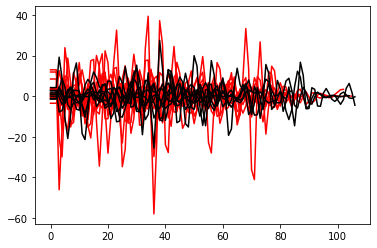

In [9]:
Subject : str ='NF12'
for s in subjects:
    try:
        A_mean_rest = DataFrameResults.loc[DataFrameResults.Subject_ID == Subject_ID, 'A_mean_rest'].values[0]
        TB_mean_rest = DataFrameResults.loc[DataFrameResults.Subject_ID == Subject_ID, 'TB_mean_REST'].values[0]                    
        mm = all_results_data[s,'BBP','TB','Trial2']
        vel  = three_point_difference(mm[:,1],mm[:,0])
        acc = three_point_difference(vel,mm[:,0])
        if 'NF' in s:
            plt.plot(acc, color='r')
        else:
            plt.plot(acc,color='k')
            
        print(s,np.var(acc))
    except:
        pass
(np.max(mm[:,1])-np.min(mm[:,1]))/TB_mean_rest
#np.mean(mm[:,1])/TB_mean_rest

In [616]:
Subject : str ='NF19'
A_mean_rest = DataFrameResults.loc[DataFrameResults.Subject_ID == Subject_ID, 'A_mean_rest'].values[0]
TB_mean_rest = DataFrameResults.loc[DataFrameResults.Subject_ID == Subject_ID, 'TB_mean_REST'].values[0]                    
mm = all_results_data[Subject,'BBP','TB','Trial2']
vel  = three_point_difference(mm[:,1],mm[:,0])
acc = three_point_difference(vel,mm[:,0])
plt.plot(mm[:,1])
TB_vel = vel
low_vel = TB_vel[(TB_vel<np.percentile(TB_vel, 75)) & (TB_vel>np.percentile(TB_vel, 25))]
len(TB_vel[(TB_vel<np.percentile(TB_vel, 75)) & (TB_vel>np.percentile(TB_vel, 25))])/len(TB_vel)

0.49056603773584906

In [44]:
%matplotlib qt
plt.rcParams.update({'font.size': 28})
plt.rc('text', usetex=False)
tasks = ['BBP', 'PA', 'BIGSMILE']
features= [['Duration','max_TB', 'max_TB_vel', 'min_TB_vel','Mean_Area', 'Delta_Area','CCC_Area' ],
           ['Duration','max_TB', 'max_TB_vel', 'min_TB_vel'],
           ['Mean_Area', 'Delta_Area','CCC_Area']]
task_features = ['Duration','Max_Vertical','Vertical_ROM','Max_Horizontal','Horizontal_ROM',
                 'LL_Path','Max_LL_vel','Min_LL_vel','Max_LL_acc', 'Min_LL_acc',
                 'Max_WM_vel','Min_WM_vel','Max_WM_acc', 'Min_WM_acc'
                 'Mean_Area','Delta_Area','CCC_Area','Range_excen','LL_Path_RMSE']

color_list = ['#DAD870', '#FFCD58', '#FF9636', '#FF5C4D', '#E80000', '#1E73BE', '#C850B0', '#660A60', '#010100', '#9BCCFD', '#0074DD', '#4120A9', '#B6D084', '#335120']
t = 2
f = 15

tp1 = np.empty((0,))
for k in range(13):
    if k == 66:
        continue
    else:
        PD1 = PD.loc[subjects[k],tasks[t],task_features[f]]
        temp = PD1.values
        temp = temp[~np.isnan(temp)]
        temp = temp[np.nonzero(temp)]

        rdnumbers = np.random.uniform(-0.075,0.075,len(temp))
        s =  rdnumbers+1
        plt.scatter(s,temp,c=color_list[k],alpha=0.5)

        tp1 = np.concatenate((temp, tp1))

tp2 = np.empty((0,))
for k in range(8):
    PD2 = PD.loc[subjects[k+13],tasks[t],task_features[f]]
    temp = PD2.values
    temp = temp[~np.isnan(temp)]
    temp = temp[np.nonzero(temp)]
    
    rdnumbers = np.random.uniform(-0.075,0.075,len(temp))
    s =  rdnumbers+2
    plt.scatter(s,temp,c=color_list[k],alpha=0.5)
    
    tp2 = np.concatenate((temp, tp2))
    
    
S = np.sqrt(((len(tp1)-1)*np.var(tp1) + (len(tp2)-1)*np.var(tp2))/(len(tp1)+len(tp2)-2))
SMD = (np.mean(tp1) - np.mean(tp2))/S

bp = plt.boxplot([tp1,tp2], notch=0, sym='', vert=1, whis=1.5, showfliers=False)
plt.setp(bp['boxes'], color='black',linewidth=4)
plt.setp(bp['whiskers'], color='black',linewidth=4)
plt.setp(bp['fliers'], color='red', marker='+',linewidth=4)
plt.setp(bp['medians'], color='red', linewidth=4)
plt.setp(bp['caps'], color='black',linewidth=4)
plt.xticks([1,2],['Healthy Control', 'Parkinsons Disease'])
plt.title(tasks[t]+' - '+task_features[f]+ ' -- '+str(np.round(SMD,2)))
plt.show()

In [48]:
tasks = ['BBP', 'PA', 'BIGSMILE']
features= [['Duration','max_TB', 'max_TB_vel', 'min_TB_vel','Mean_Area', 'Delta_Area','CCC_Area' ],
                ['Duration','max_TB', 'max_TB_vel', 'min_TB_vel'],
                ['Mean_Area', 'Delta_Area','CCC_Area']]
task_features = ['Duration','Max_Vertical','Vertical_ROM','Max_Horizontal','Horizontal_ROM',
                 'LL_Path','Max_LL_vel','Min_LL_vel','Max_LL_acc', 'Min_LL_acc',
                 'Max_WM_vel','Min_WM_vel','Max_WM_acc', 'Min_WM_acc',
                 'Mean_Area','Delta_Area','CCC_Area','Range_excen','LL_Path_RMSE']

selected_features = ['Vertical_ROM','Max_LL_vel','Min_LL_vel','Max_LL_acc', 'Min_LL_acc',                
                 'Horizontal_ROM','Max_WM_vel','Min_WM_vel','Max_WM_acc', 'Min_WM_acc',
                 'Mean_Area','Delta_Area','CCC_Area','Range_excen']

array_two = []
array_three = []
SMD = []
M_h= []
STD_h = []
M_PD= []
STD_PD = []
for t,c2 in enumerate(tasks):
    for f,c3 in enumerate(selected_features):
        array_two.append(c2)
        array_three.append(c3)
        
        PD1 = PD.loc[subjects[0:13],c2,c3]
        PD2 = PD.loc[subjects[13:],c2,c3]
        tp1 = np.concatenate(PD1.values)
        tp1 = tp1[~np.isnan(tp1)]
        tp1 = tp1[np.nonzero(tp1)]
        tp2 = np.concatenate(PD2.values)
        tp2 = tp2[~np.isnan(tp2)]
        tp2 = tp2[np.nonzero(tp2)]
        
        #KW.append(stats.kruskal(tp1,tp2).pvalue)
        #ANOVA.append(stats.f_oneway(tp1,tp2).pvalue)
        
        #S = ((np.std(tp1)**2/len(tp1) + np.std(tp2)**2/len(tp2)) * (len(tp1)*len(tp2)/(len(tp1)+len(tp2))))
        S = np.sqrt(((len(tp1)-1)*np.var(tp1) + (len(tp2)-1)*np.var(tp2))/(len(tp1)+len(tp2)-2))
        SMD.append(np.round((np.mean(tp1) - np.mean(tp2))/S,2))
        
        M_h.append(np.mean(tp1))
        STD_h.append(np.std(tp1))
        M_PD.append(np.mean(tp2))
        STD_PD.append(np.std(tp2))
        
midx = pd.MultiIndex.from_arrays([array_two, array_three],  
          names =('Task', 'Feature')) 
PD_eval=pd.DataFrame(index = midx)
PD_eval['SMD'] = SMD
PD_eval['M-H'] = M_h
PD_eval['STD-H'] = STD_h
PD_eval['M-PD'] = M_PD
PD_eval['STD-PD'] = STD_PD
#PD_eval['ANOVA'] = ANOVA
#PD_eval['Kruskal–Wallis'] = KW
pd.options.display.float_format = '{:.4f}'.format
PD_eval

SMD        M-H     STD-H      M-PD   STD-PD
Task     Feature                                                       
BBP      Vertical_ROM    0.9000     1.7713    0.9020    1.1022   0.3452
         Max_LL_vel      0.8600    36.1623   27.5691   17.2500   6.0865
         Min_LL_vel     -0.6700   -30.7229   26.1326  -16.8237   5.5127
         Max_LL_acc      0.7600  1836.2459 1605.0324  868.8728 346.1196
         Min_LL_acc     -0.7500 -2312.3038 2404.5414 -880.4574 365.0401
         Horizontal_ROM  0.1100     0.2120    0.9963    0.1266   0.0448
         Max_WM_vel      0.1000     4.5702   26.2664    2.5136   1.6005
         Min_WM_vel     -0.1100    -4.7808   26.7633   -2.4972   1.4381
         Max_WM_acc      0.1000   271.5783 1426.7348  155.4956 115.7170
         Min_WM_acc     -0.1100  -282.4795 1437.4116 -154.9786 121.4384
         Mean_Area       0.3200     1.5907    0.2582    1.5114   0.2220
         Delta_Area      0.6100     1.7834    1.1997    1.1845   0.4176
         CCC_Area        0.1800     0.7692    0.1670    0.7354   0.2070
         Range_excen     0.6100     0.2792    0.1877    0.1825   0.0977
PA       Vertical_ROM    0.4000     1.0933    0.8290    0.8045   0.3873
         Max_LL_vel      0.4900    23.4494   21.0600   14.6171   7.9787
         Min_LL_vel     -0.3900   -21.4487   18.7008  -15.1407   7.3893
         Max_LL_acc      0.4400  1078.9415  993.7864  705.7833 338.4219
         Min_LL_acc     -0.4800 -1305.7940 1347.7665 -751.9224 456.3722
         Horizontal_ROM -0.0600     0.0561    0.0462    0.0590   0.0392
         Max_WM_vel      0.0600     1.3963    1.2071    1.3252   0.9020
         Min_WM_vel      0.0200    -1.2805    1.1181   -1.3014   0.8716
         Max_WM_acc      0.0200    84.6174   69.5879   83.2656  53.7581
         Min_WM_acc     -0.0300   -84.7063   75.4374  -82.6397  51.7627
         Mean_Area      -0.1000     1.4771    0.3089    1.5066   0.3036
         Delta_Area      0.2400     1.0213    0.8238    0.8439   0.5198
         CCC_Area        0.0700     0.8060    0.1724    0.7946   0.1647
         Range_excen     0.1200     0.1479    0.1338    0.1322   0.1256
BIGSMILE Vertical_ROM    0.2400     1.0496    0.4247    0.9481   0.3980
         Max_LL_vel      0.1200    12.7966    4.5048   12.1490   6.5412
         Min_LL_vel     -0.0200   -12.2571    5.3804  -12.1326   5.6958
         Max_LL_acc     -0.0500   839.4169  378.5958  857.9844 461.8034
         Min_LL_acc     -0.0000  -852.3971  339.5304 -851.7253 454.4079
         Horizontal_ROM  0.8500     0.3041    0.0732    0.2309   0.1037
         Max_WM_vel      0.1200     3.0804    0.8928    2.9651   1.0398
         Min_WM_vel     -0.6600    -3.4573    0.9667   -2.8570   0.8243
         Max_WM_acc      0.2200   202.5698   60.7190  189.7601  53.4756
         Min_WM_acc      0.0800  -196.4910   63.1327 -201.4002  68.3596
         Mean_Area       0.0400     2.0560    0.3963    2.0376   0.4947
         Delta_Area      0.2500     1.6951    0.6614    1.5221   0.7372
         CCC_Area        0.5500     0.8739    0.1395    0.7931   0.1609
         Range_excen    -0.4900     0.0690    0.0380    0.0913   0.0565

In [28]:
subjects = ['NF12', 'NF13', 'NF14', 'NF15', 'NF16', 'NF17', 'NF18', 'NF19', 'NF20', 'NF21', 'NF22', 'NF23', 'NF24', 'NF26', 'PD01', 'PD02', 'PD03', 'PD04', 'PD05', 'PD06', 'PD07', 'PD08']
tasks = ['BBP', 'PA', 'BIGSMILE']
task_features = ['Duration','Vertical_ROM','Horizontal_ROM','LL_Path','Max_LL_vel','Min_LL_vel','Max_WM_vel','Min_WM_vel','Mean_Area','Delta_Area','CCC_Area','Range_excen','LL_Path_difference']
features= [['Duration','max_TB', 'max_TB_vel', 'min_TB_vel','Mean_Area', 'Delta_Area','CCC_Area' ],
                ['Duration','max_TB', 'max_TB_vel', 'min_TB_vel'],
                ['Mean_Area', 'Delta_Area','CCC_Area']]

task_features = ['Duration','Max_Vertical','Vertical_ROM','Max_Horizontal','Horizontal_ROM',
                 'LL_Path','Max_LL_vel','Min_LL_vel','Max_LL_acc', 'Min_LL_acc',
                 'Max_WM_vel','Min_WM_vel','Max_WM_acc', 'Min_WM_acc'
                 'Mean_Area','Delta_Area','CCC_Area','Range_excen','LL_Path_RMSE']

df_cols= ['Subject_ID','Duration','Max_Vertical','Vertical_ROM','Max_Horizontal','Horizontal_ROM',
                 'LL_Path','Max_LL_vel','Min_LL_vel','Max_LL_acc', 'Min_LL_acc',
                 'Max_WM_vel','Min_WM_vel','Max_WM_acc', 'Min_WM_acc'
                 'Mean_Area','Delta_Area','CCC_Area','Range_excen','LL_Path_RMSE','Label']

DF_BBP= pd.DataFrame(columns = df_cols)
df_cols_PA= ['Subject_ID','Duration','Vertical_ROM','Horizontal_ROM','LL_Path','Max_LL_vel','Min_LL_vel','Max_WM_vel','Min_WM_vel','Mean_Area','Delta_Area','CCC_Area','Range_excen','LL_Path_difference','Label']
DF_PA= pd.DataFrame(columns = df_cols)
df_cols_BIGSMILE= ['Subject_ID','Duration','Vertical_ROM','Horizontal_ROM','LL_Path','Max_LL_vel','Min_LL_vel','Max_WM_vel','Min_WM_vel','Mean_Area','Delta_Area','CCC_Area','Range_excen','LL_Path_difference','Label']
DF_BIGSMILE= pd.DataFrame(columns = df_cols)

DF_cols_BBP = df_cols
DF_cols_PA = df_cols
DF_cols_BIGSMILE = df_cols

for t,c2 in enumerate(tasks):
    for s in subjects:
        to_carry = np.empty(0)
        
        if c2 == 'BBP':
            PD1 = PD.loc[s, c2].values[:]
            n_trials = PD1[0][~np.isnan(PD1[0])].shape[0]
            n_features = PD1.shape[0]
            to_carry = np.broadcast_to(np.array(s),(n_trials,1))
            for m in PD1:
                m1 = m[~np.isnan(m)]
                to_carry = np.column_stack((to_carry,m1))
            
            if 'NF' in s:
                to_carry=np.column_stack((to_carry,np.zeros((to_carry.shape[0],1))))
            else:
                to_carry=np.column_stack((to_carry,np.ones((to_carry.shape[0],1))))
            
            for m in to_carry:
                DF_BBP = DF_BBP.append(pd.Series(m,index = df_cols), ignore_index = True)
            
        if c2 == 'PA':
            PD1 = PD.loc[s, c2].values[:]
            n_trials = PD1[0][~np.isnan(PD1[0])].shape[0]
            n_features = PD1.shape[0]
            to_carry = np.broadcast_to(np.array(s),(n_trials,1))
            for m in PD1:
                m1 = m[~np.isnan(m)]
                to_carry = np.column_stack((to_carry,m1))
            
            if 'NF' in s:
                to_carry=np.column_stack((to_carry,np.zeros((to_carry.shape[0],1))))
            else:
                to_carry=np.column_stack((to_carry,np.ones((to_carry.shape[0],1))))
            
            for m in to_carry:
                DF_PA = DF_PA.append(pd.Series(m,index = df_cols), ignore_index = True)
            
            
        if c2 == 'BIGSMILE':
            PD1 = PD.loc[s, c2].values[:]
            n_trials = PD1[0][~np.isnan(PD1[0])].shape[0]
            n_features = PD1.shape[0]
            to_carry = np.broadcast_to(np.array(s),(n_trials,1))
            for m in PD1:
                m1 = m[~np.isnan(m)]
                to_carry = np.column_stack((to_carry,m1))
            
            if 'NF' in s:
                to_carry=np.column_stack((to_carry,np.zeros((to_carry.shape[0],1))))
            else:
                to_carry=np.column_stack((to_carry,np.ones((to_carry.shape[0],1))))
            
            for m in to_carry:
                DF_BIGSMILE = DF_BIGSMILE.append(pd.Series(m,index = df_cols), ignore_index = True)
        

DF_BBP.to_csv(r"C:\Users\GuarinD\Documents\GitHub\Face_and_Gestures_2020\data\NewFeatures2d_BBP.csv")
DF_PA.to_csv(r"C:\Users\GuarinD\Documents\GitHub\Face_and_Gestures_2020\data\NewFeatures2d_PA.csv")
DF_BIGSMILE.to_csv(r"C:\Users\GuarinD\Documents\GitHub\Face_and_Gestures_2020\data\NewFeatures2d_BIGSMILE.csv")

In [631]:
PD.loc[s, c2]

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
CCC_Area,-0.0917,-0.1083,-0.1320,-0.0614,-0.0791,-0.1400,-0.1252,-0.0525,-0.0934,-0.1016,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Delta_Area,0.1039,0.0950,0.1141,0.1233,0.0537,0.0763,0.1336,0.0517,0.0982,0.0969,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Duration,1.0994,1.1393,1.1993,1.0994,1.0594,1.0194,1.1194,1.0794,1.1993,1.1593,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Horizontal_ROM,1.4488,0.9620,0.8315,0.7536,0.6273,0.5764,0.6060,0.7222,0.6848,0.6777,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
LL_Path,1.0527,1.0499,1.0527,1.0407,1.0477,1.0948,1.0599,1.0471,1.0471,1.0469,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
LL_Path_RMSE,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
LL_Path_difference,1.3775,1.3089,1.2849,1.2793,1.2619,1.2735,1.3067,1.3036,1.3175,1.3398,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Max_Horizontal_ROM,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Max_LL_vel,0.0948,0.1057,0.1191,0.1008,0.0954,0.1091,0.1051,0.0536,0.0918,0.1244,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Max_Vertical_ROM,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


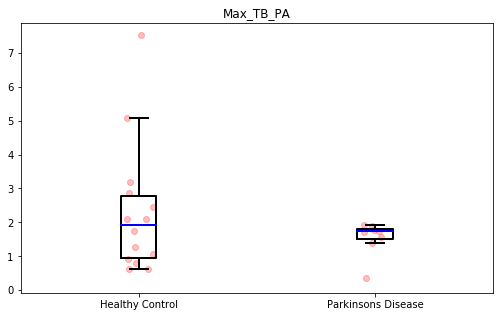

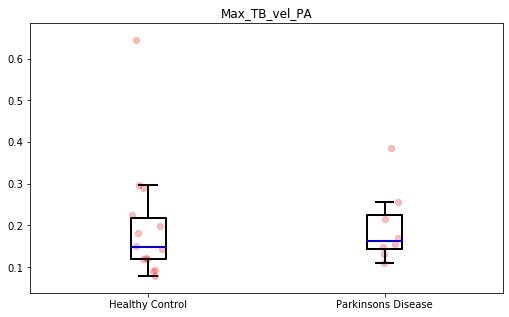

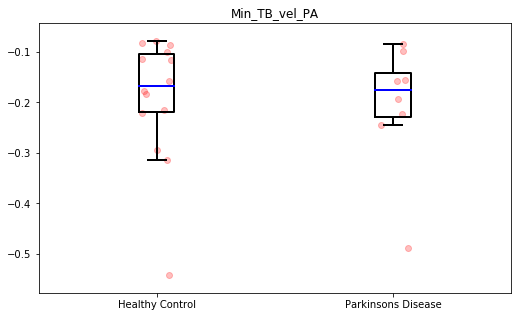

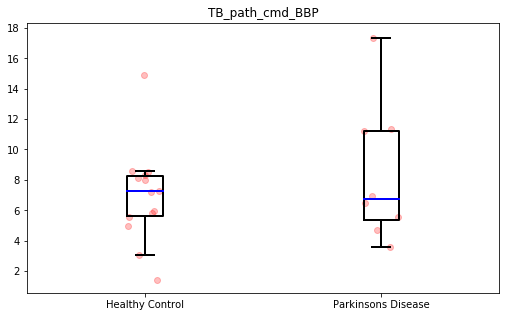

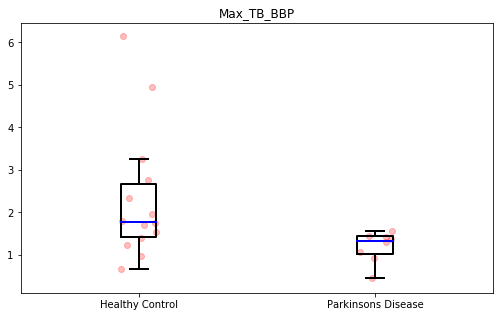

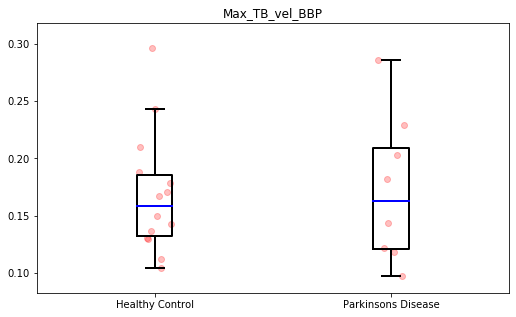

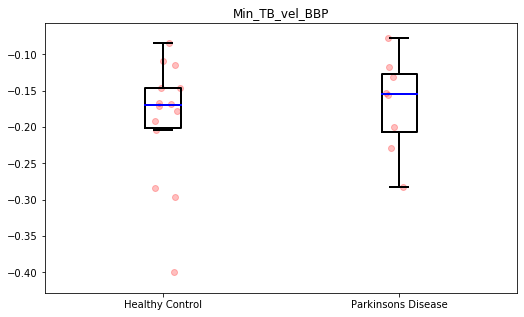

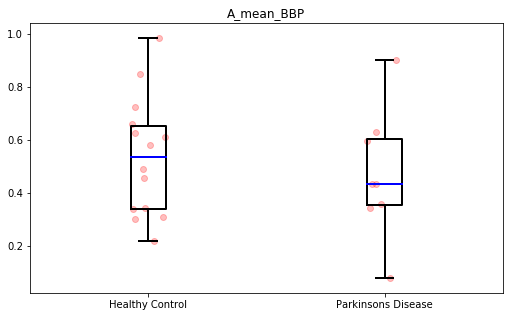

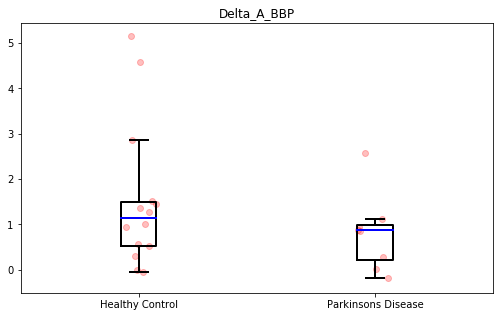

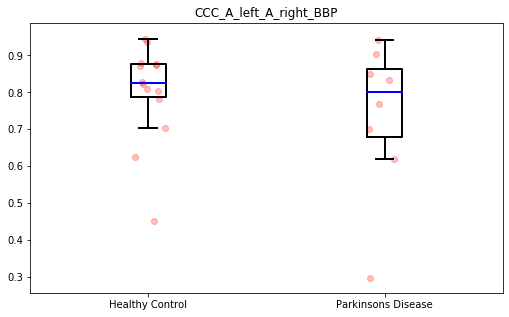

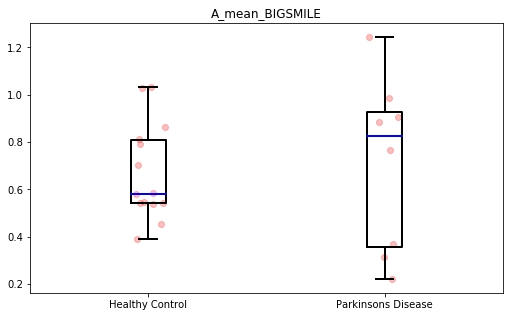

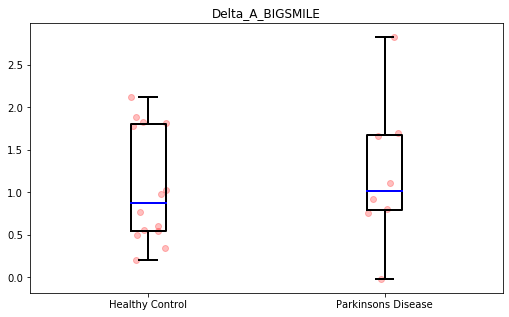

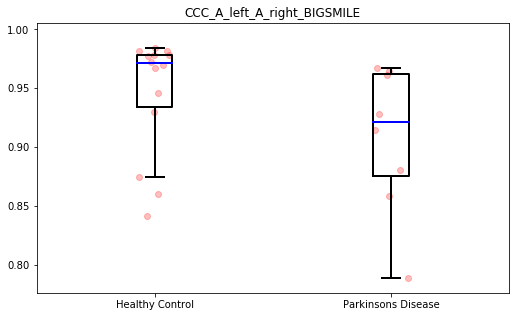

In [302]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
Variables_to_analize = [         
            #'Duration_var_PA', 
            'Max_TB_PA',
            'Max_TB_vel_PA', 
            'Min_TB_vel_PA', 
            'TB_path_cmd_BBP',
            'Max_TB_BBP',
            'Max_TB_vel_BBP', 
            'Min_TB_vel_BBP', 
            'A_mean_BBP', 
            'Delta_A_BBP', 
            'CCC_A_left_A_right_BBP', 
            'A_mean_BIGSMILE',
            'Delta_A_BIGSMILE', 
            'CCC_A_left_A_right_BIGSMILE'
          ]

for variable in Variables_to_analize:
    data1 = DataFrameResults.loc[DataFrameResults['Subject_status']=='NF',variable].values
    data2 = DataFrameResults.loc[DataFrameResults['Subject_status']=='PD',variable].values
    fig, ax1 = plt.subplots(figsize=(7.5,5))
    plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.15)
    
    
    rdnumbers = np.random.uniform(-0.075,0.075,len(data1))
    s =  rdnumbers+1
    plt.scatter(s,data1,c='r',alpha=0.25)
    
    rdnumbers = np.random.uniform(-0.075,0.075,len(data2))
    s =  rdnumbers+2
    plt.scatter(s,data2,c='r',alpha=0.25)
    
    
    bp = plt.boxplot([data1,data2], notch=0, sym='', vert=1, whis=1.5, showfliers=False)
    plt.setp(bp['boxes'], color='black',linewidth=2)
    plt.setp(bp['whiskers'], color='black',linewidth=2)
    plt.setp(bp['fliers'], color='red', marker='+',linewidth=2)
    plt.setp(bp['medians'], color='blue', linewidth=2)
    plt.setp(bp['caps'], color='black',linewidth=2)
    plt.title(variable)
    plt.xticks([1,2],['Healthy Control', 'Parkinsons Disease'])
    plt.show()
    
#     input("Press Enter to continue...")


In [230]:
tasks = ['BBP', 'PA', 'BIGSMILE']
features= [['Duration','max_TB', 'max_TB_vel', 'min_TB_vel','Mean_Area', 'Delta_Area','CCC_Area' ],
           ['Duration','max_TB', 'max_TB_vel', 'min_TB_vel'],
           ['Mean_Area', 'Delta_Area','CCC_Area']]
t = 1
f = 3
PD1 = PD.loc[subjects[0:13],tasks[t],features[t][f]]
PD2 = PD.loc[subjects[14:],tasks[t],features[t][f]]
tp1 = np.concatenate(PD1.values)
tp1 = tp1[~np.isnan(tp1)]
tp2 = np.concatenate(PD2.values)
tp2 = tp2[~np.isnan(tp2)]
%matplotlib qt
bp = plt.boxplot([tp1,tp2], notch=0, sym='', vert=1, whis=1.5, showfliers=False)
plt.setp(bp['boxes'], color='black',linewidth=2)
plt.setp(bp['whiskers'], color='black',linewidth=2)
plt.setp(bp['fliers'], color='red', marker='+',linewidth=2)
plt.setp(bp['medians'], color='blue', linewidth=2)
plt.setp(bp['caps'], color='black',linewidth=2)
plt.xticks([1,2],['Healthy Control', 'Parkinsons Disease'])
plt.title(tasks[t]+' - '+features[t][f])
plt.show()

In [353]:
tasks = ['BBP', 'PA', 'BIGSMILE']
features= [['Duration','max_TB', 'max_TB_vel', 'min_TB_vel','Mean_Area', 'Delta_Area','CCC_Area' ],
           ['Duration','max_TB', 'max_TB_vel', 'min_TB_vel'],
           ['Mean_Area', 'Delta_Area','CCC_Area']]
t = 0
f = 0
PD1 = PD.loc[subjects[0:13],tasks[t],features[t][f]]
PD2 = PD.loc[subjects[14:],tasks[t],features[t][f]]
tp11 = np.concatenate(PD1.values)
tp11 = tp11[~np.isnan(tp11)]
tp21 = np.concatenate(PD2.values)
tp21 = tp21[~np.isnan(tp21)]

t = 0
f = 6
PD1 = PD.loc[subjects[0:13],tasks[t],features[t][f]]
PD2 = PD.loc[subjects[14:],tasks[t],features[t][f]]
tp12 = np.concatenate(PD1.values)
tp12 = tp12[~np.isnan(tp12)]
tp22 = np.concatenate(PD2.values)
tp22 = tp22[~np.isnan(tp22)]
plt.scatter(tp11,tp12)
plt.scatter(tp21,tp22)


In [360]:
stats.kruskal(tp11,tp12).pvalue, stats.f_oneway(tp11,tp12)


7.345574645420185e-42

In [178]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

In [177]:
X = DF_BBP.iloc[:, 1:7].values
y = DF_BBP.iloc[:, 7].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
regressor = RandomForestClassifier()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print(regressor.feature_importances_)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[0.26464328 0.16079873 0.11164032 0.18285857 0.17907113 0.10098797]
[[12  1]
 [ 3  5]]
              precision    recall  f1-score   support

         0.0       0.80      0.92      0.86        13
         1.0       0.83      0.62      0.71         8

    accuracy                           0.81        21
   macro avg       0.82      0.77      0.79        21
weighted avg       0.81      0.81      0.80        21

0.8095238095238095


In [172]:
rfc_cv_score = cross_val_score(regressor, X_train, y_train, cv=10, scoring='roc_auc')
np.mean(rfc_cv_score), np.std(rfc_cv_score)


(0.8761363636363637, 0.06797548746596142)

In [163]:
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 5)]
# number of features at every split
max_features = ['auto','log2', None]

# max depth
max_depth = [int(x) for x in np.linspace(1, 20, num = 20)]
max_depth.append(None)

criterion = ['gini', 'entropy']
# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth,
 'criterion' : criterion
 }
# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the model
rfc_random.fit(X_train, y_train)
# print results
print(rfc_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s


{'n_estimators': 50, 'max_features': 'auto', 'max_depth': 20}


[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 277 out of 300 | elapsed:    2.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.4s finished


In [180]:
X = DF_BBP.iloc[:, 1:7].values
y = DF_BBP.iloc[:, 7].values
idx = range(0,len(X))
ss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
regressor = RandomForestClassifier()
acc = []
feat_importance = []
for train_index, test_index in ss.split(X,y):
    X_train, y_train, X_test, y_test = X[train_index], y[train_index], X[test_index],y[test_index]
    regressor.fit(X_train, y_train.astype(int))
    y_pred = regressor.predict(X_test)
    acc.append(accuracy_score(y_test, y_pred))
    feat_importance.append(regressor.feature_importances_)

print(np.mean(acc), np.std(acc))
print(np.mean(np.array(feat_importance),axis=0))

0.8341463414634147 0.06794335744967864
[0.26728224 0.15206544 0.12065584 0.17971774 0.1641676  0.11611114]


In [242]:
y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])